<a href="https://colab.research.google.com/github/AlexKalll/qc-workarounds/blob/main/QC_CHSH_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHSH Game: Violating Bell's Inequality with Qiskit

Implementing CHSH game protocol using Qiskit. We simulate two parties, Alice and Bob, sharing an entangled Bell pair. By measuring their qubits in specific bases determined by random inputs, we demonstrate that they can achieve correlations.

#### Setup

In [ ]:
!pip install qiskit qiskit-aer pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.7 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=6f5c983ff71da90ec7e4a7a3eb36abeea094c793870329dd4ec78d0aaea47bbb
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


#### **Import packages**

In [ ]:
import numpy as np
import math
import pandas as pd
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Set the simulator
simulator = Aer.get_backend('qasm_simulator')
print("Imports successful. Using simulator:", simulator)

Imports successful. Using simulator: QasmSimulator('qasm_simulator')


Example Circuit for x=0, y=0:


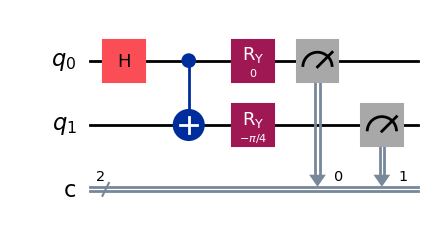

In [ ]:
def make_chsh_circuit(theta_alice, theta_bob):
    """
    Creates a quantum circuit for one instance of the CHSH game.
    Args:
        theta_alice (float): Rotation angle for Alice's measurement basis.
        theta_bob (float): Rotation angle for Bob's measurement basis.
    Returns:
        QuantumCircuit: The constructed circuit.
    """
    qc = QuantumCircuit(2, 2)

    # Prepare Bell State |Phi+> = (|00> + |11>) / sqrt(2)
    qc.h(0)
    qc.cx(0, 1)

    # Rotate measurement bases
    qc.ry(-theta_alice, 0)
    qc.ry(-theta_bob, 1)

    qc.measure([0, 1], [0, 1])

    return qc

print("Example Circuit for x=0, y=0:")
display(make_chsh_circuit(0, np.pi/4).draw('mpl'))

#### **Simulation & Calculation**

In [ ]:
# Define angles corresponding to inputs x and y
# Alice: 0 -> 0, 1 -> pi/2
# Bob:   0 -> pi/4, 1 -> -pi/4
angles_alice = {0: 0, 1: np.pi/2}
angles_bob   = {0: np.pi/4, 1: -np.pi/4}

shots = 5000
results_data = []
correlations = {}

print(f"Running simulation with {shots} shots per pair...\n")

# Loop through all 4 input pairs (0,0), (0,1), (1,0), (1,1)
for x in [0, 1]:
    for y in [0, 1]:
        theta_a = angles_alice[x]
        theta_b = angles_bob[y]

        # Build circuit
        qc = make_chsh_circuit(theta_a, theta_b)

        # Run simulation
        job = simulator.run(qc, shots=shots)
        result = job.result()
        counts = result.get_counts()

        # Calculate counts for outcomes 00, 01, 10, 11
        same_count = counts.get('00', 0) + counts.get('11', 0)
        diff_count = counts.get('01', 0) + counts.get('10', 0)

        # Calculate Probability and Correlation
        total = same_count + diff_count
        prob_same = same_count / total
        prob_diff = diff_count / total
        E_xy = prob_same - prob_diff

        # Store correlation
        correlations[(x,y)] = E_xy

        # Check win condition for the game (Win if a XOR b == x AND y)
        # if x*y == 0, we want a == b (same).
        # if x*y == 1, we want a != b (diff).
        if (x * y) == 0:
            win_prob = prob_same
        else:
            win_prob = prob_diff

        results_data.append({
            "x (Alice)": x,
            "y (Bob)": y,
            "Angle Alice": round(theta_a, 2),
            "Angle Bob": round(theta_b, 2),
            "Correlation E(x,y)": E_xy,
            "Win Probability": win_prob
        })

# Compute CHSH S value
# S = E(0,0) + E(0,1) + E(1,0) - E(1,1)
S_value = correlations[(0,0)] + correlations[(0,1)] + correlations[(1,0)] - correlations[(1,1)]

# Display Results
df_results = pd.DataFrame(results_data)
print(df_results)
print("\n" + "="*40)
print(f"Calculated CHSH Value S = {S_value:.4f}")
print("="*40)

# Theoretical Max
print(f"Classical Limit: 2.0")
print(f"Quantum Limit:   {2 * np.sqrt(2):.4f}")

Running simulation with 5000 shots per pair...

   x (Alice)  y (Bob)  Angle Alice  Angle Bob  Correlation E(x,y)  \
0          0        0         0.00       0.79              0.7072   
1          0        1         0.00      -0.79              0.7116   
2          1        0         1.57       0.79              0.7220   
3          1        1         1.57      -0.79             -0.7004   

   Win Probability  
0           0.8536  
1           0.8558  
2           0.8610  
3           0.8502  

Calculated CHSH Value S = 2.8412
Classical Limit: 2.0
Quantum Limit:   2.8284


#### **Visualization**

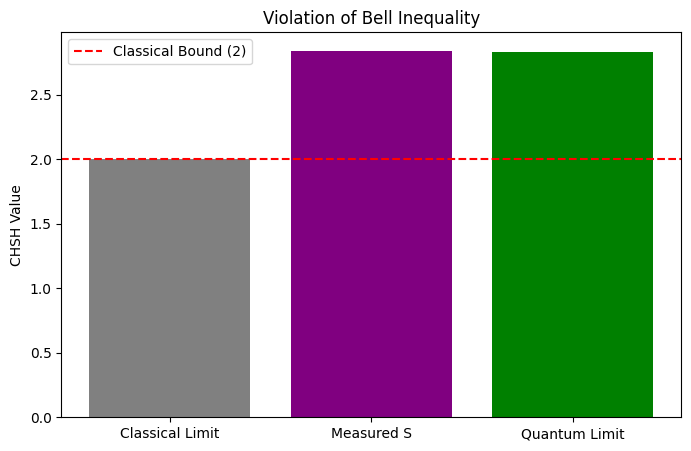

In [ ]:
# Visualize the S value compared to limits
plt.figure(figsize=(8, 5))
plt.bar(['Classical Limit', 'Measured S', 'Quantum Limit'],
        [2.0, S_value, 2 * np.sqrt(2)],
        color=['gray', 'purple', 'green'])
plt.axhline(y=2.0, color='r', linestyle='--', label='Classical Bound (2)')
plt.ylabel('CHSH Value')
plt.title('Violation of Bell Inequality')
plt.legend()
plt.show()

## Interpretation of Results

1.  **Violation:** The calculated $S$ value (2.8) significantly exceeds the classical bound of 2. This empirically proves that the description of reality provided by local hidden variable theories is incomplete.
2.  **Entanglement Power:** The result relies entirely on the entanglement of the pair.
3.  **Game Win Rate:**
    * In the classical case, the best average win rate is 75%.
    * Looking at our `Win Probability` column, we see win rates consistently around 85% for all input pairs.

In [ ]:
# Save results to CSV for download
csv_filename = "chsh_results.csv"
df_results.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

from google.colab import files

Results saved to chsh_results.csv
